# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

1. Data (predpare and load)
2. Build model
3. Fitting the model to data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.7.1'

## 1. Data (preparing and loading)
Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some know data using the linear regression formula.

In [2]:
# Create *know* parameters
# Simulated Data

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

In [3]:
X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [4]:
y[:10]

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])

In [5]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [6]:
X_train.shape

torch.Size([40, 1])

In [7]:
X_test.shape

torch.Size([10, 1])

In [8]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):
    """"
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize = (8, 7))

    #Plot training data in blue
    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = "Training data")

    #Plot test data in green
    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = "Testing data")

    # Are there predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = "Predictions")

    # Show the legend
    plt.legend(prop = {"size": 12});
    plt.show()

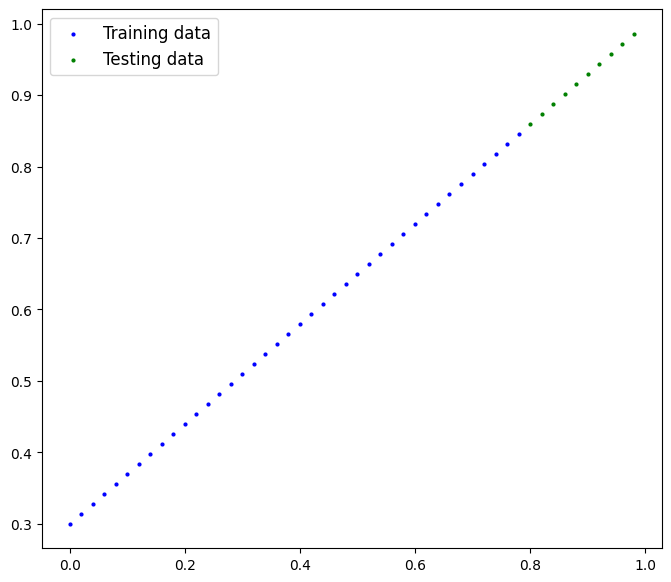

In [9]:
plot_predictions(X_train, y_train, X_test, y_test);

## 2. Build model

OOP resource: [link](https://realpython.com/python3-object-oriented-programming/)

What our model does:
- Start with random values (weihgt and bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values.

In [10]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype = torch.float))

        # requires_grad -> Can this parameter be updated via gradient descent?
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype = torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # This is the linear regression formula

In [11]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [13]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [14]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [15]:
# Making predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do somthing similar with torch.no_grad()
# with torch.inference_mode():
#     y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [16]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

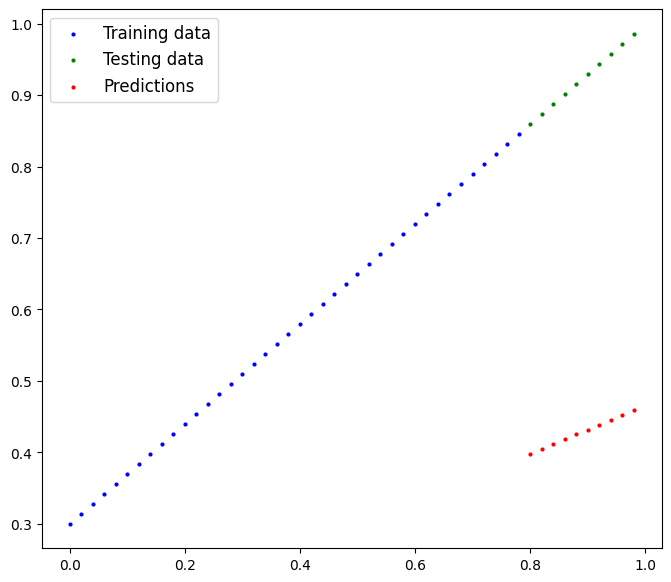

In [17]:
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds);

## 3. Train model

Things we need to train:
- **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
- **Opimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias).

In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [20]:
# Setup a loss function
loss_fn = nn.L1Loss()

In [21]:
# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(), # we want to optimize the parameters present in our model.
                            lr = 0.01 # lr = learning rate = possibly the most important hyperparameters you can set.,
                            )

### Building a training loop (and a testing loop) in PyTorch
0. Loop through the data and do ...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predicts on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth laels)
3. Optimize zero grad
4. Loss backward - move backwards through the netwokr to calculate the gradients of each of the parameters of our model with respect to the the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss. (**gradient descent**)

In [22]:
# And epoch is one loop through the data...
epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Train mode in PyTorch set all parameters that require gradient to "require gradient"

    # 1. Forward pass
    y_preds = model_0(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)
    # print(f'Loss : {loss}')
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Perform bakcpropagation on the loss with respect to the parameters of the model
    loss.backward()
    #5. Step the optimizer (perform gradient descent)
    optimizer.step()

    model_0.eval() # Truns off different settings in the model not needed for evalueation/testing (dropout/bath norm layers)

    with torch.inference_mode(): # Truns off gradient tracking and a couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}\n")
        #print out model state_dict()
        print(model_0.state_dict())
        print('='*70+'\n')

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.48106518387794495

OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})

Epoch: 10 | Loss: 0.1976713389158249 | Test loss: 0.3463551998138428

OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})

Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.2172965705394745

OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})

Epoch: 30 | Loss: 0.053148530423641205 | Test loss: 0.14464019238948822

OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})

Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953748226166

OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})

Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024

OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})

Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633813381195

OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})

Epoch: 70

## 4. Making predictions and evaluating a model (inference)

In [23]:
with torch.inference_mode():
    y_preds = model_0(X_test)

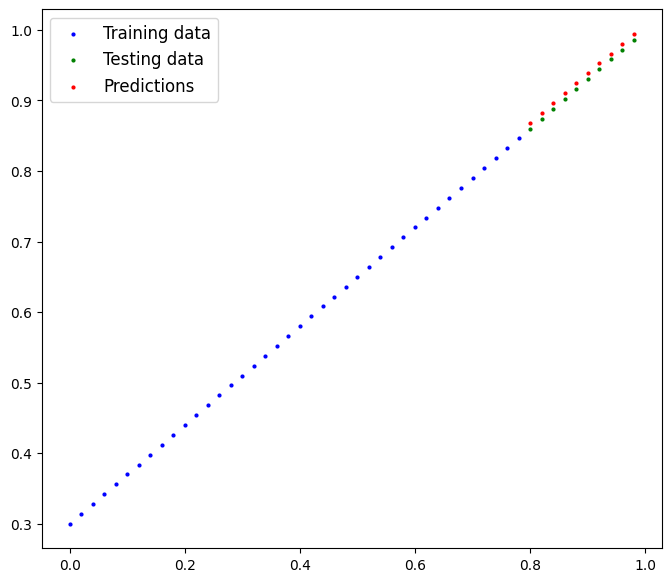

In [24]:
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds);

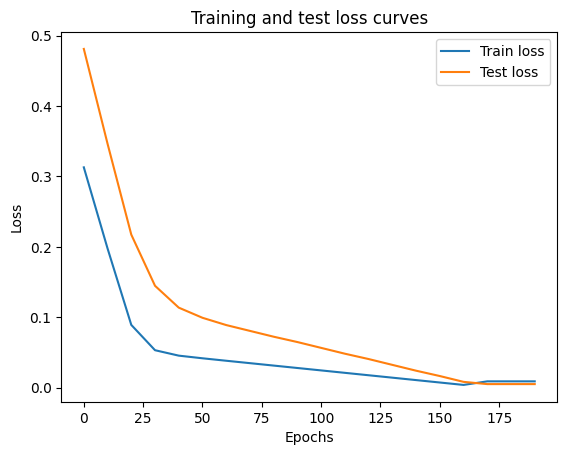

In [25]:
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label = 'Train loss')
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label = 'Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

## 5. Saving a model in PyTorch
There are three main methods you should about for saving and loading models in PyTorch.
1. `torch.save` - allows you save a PyTorch object in Python's pickle format
2. `torhc.load` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary.

In [26]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [28]:
# 1. Create models directory
MODEL_PATH = 'model/'

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pt'
MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

# 3. Save the model state dict
print(f"save model to: {MODEL_PATH}")
torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

save model to: model/


In [29]:
torch.load(f = MODEL_SAVE_PATH, weights_only=True)

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
# To load in a saved state_dict we have to instantiate a dnew instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with undated parameters)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH, weights_only=True))

<All keys matched successfully>

In [31]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    laoded_model_preds = loaded_model_0(X_test)
laoded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
# Make some model predictions
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [33]:
# Compare loaded model preds with original model preds
y_preds == laoded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])